In [15]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read words
words = open("names.txt", "r").read().splitlines()

# Build vocabulary of all characters and mapping to/from integer
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(chars) + 1

g = torch.Generator().manual_seed(2147483647)

In [3]:
block_size = 3
# build the dataset
def build_dataset(words):
    # context length: how many characters do we take to predict next one?
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [9]:
# Lets create a deeper network
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5   # Kaiming normal distribution
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight 
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [10]:
class BatchNormald:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters(trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)    # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [11]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [27]:
# Create MLP
n_embd = 10     # dimensionality of character embedding vectors
n_hidden = 100  # number of neurons in the hidden layer of MLP
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNormald(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNormald(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNormald(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNormald(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNormald(vocab_size), 
]

with torch.no_grad():
    # last layer: make less confident
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    # all other layers: apply again
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # gain
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47351


In [28]:
# optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update 
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # tracking stat
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}:',loss.item())
    lossi.append(loss)
    
    break
        

      0/ 200000: 3.278627395629883


layer 1 (      Tanh): mean -0.00, std 0.20, saturated: 0.00%
layer 4 (      Tanh): mean +0.01, std 0.63, saturated: 3.22%
layer 7 (      Tanh): mean -0.00, std 0.63, saturated: 2.66%
layer 10 (      Tanh): mean -0.00, std 0.63, saturated: 3.03%
layer 13 (      Tanh): mean -0.00, std 0.64, saturated: 2.38%


Text(0.5, 1.0, 'activation distribution')

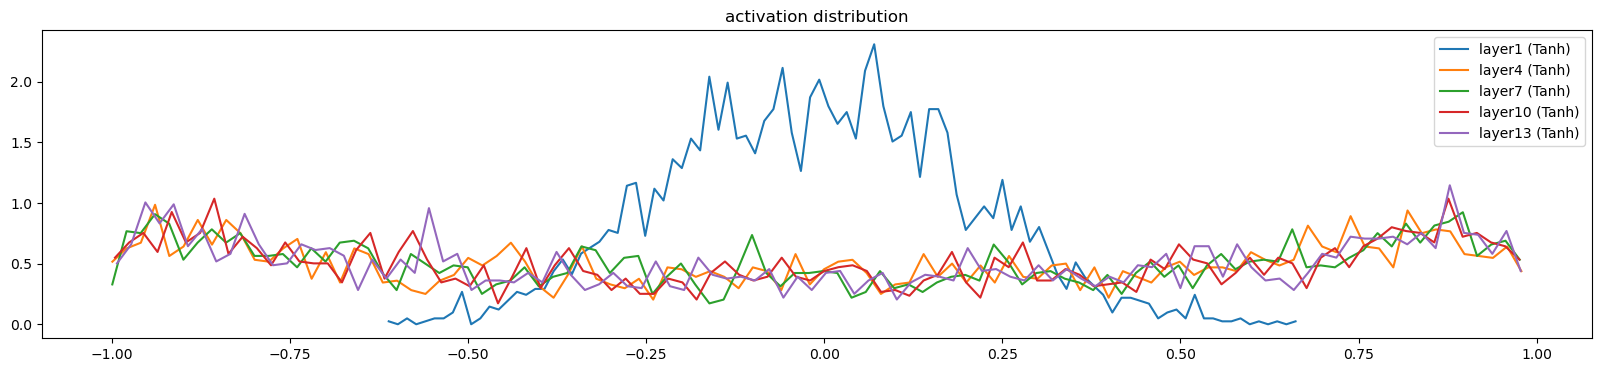

In [29]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer{i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

layer 1 (      list): mean +0.000000, std 3.135429e-03
layer 4 (      list): mean +0.000000, std 7.627151e-04
layer 7 (      list): mean -0.000000, std 6.583228e-04
layer 10 (      list): mean -0.000000, std 5.644831e-04
layer 13 (      list): mean -0.000000, std 5.118702e-04


Text(0.5, 1.0, 'gradient distribution')

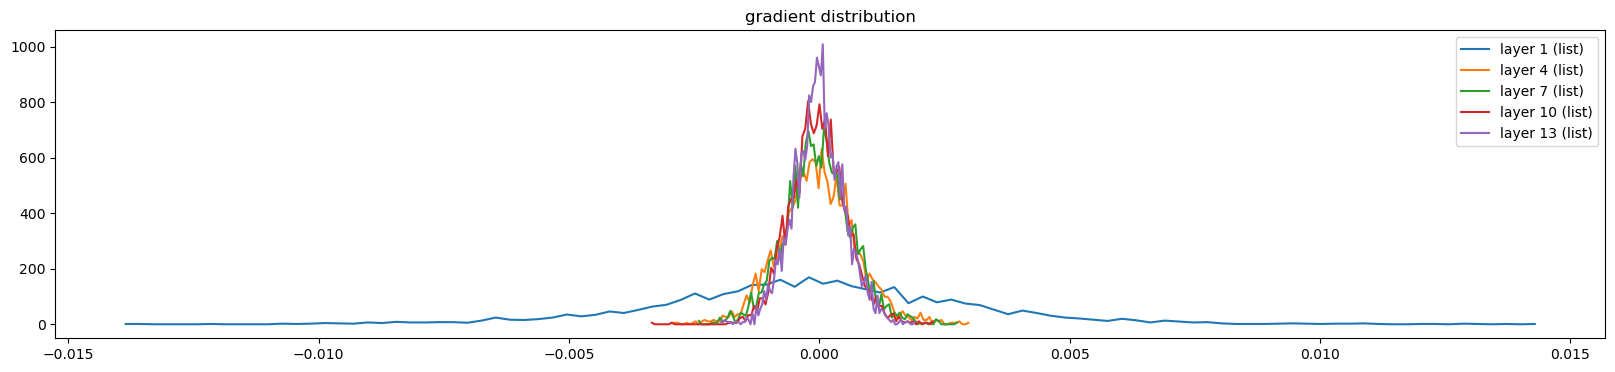

In [30]:
# visualize grad histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layers.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layers.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')